In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterGrid
from tensorflow.keras import layers
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers

#for data preprocessing
from sklearn.decomposition import PCA

from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                            recall_score, f1_score, roc_auc_score, mean_squared_error, roc_curve,
                            classification_report,precision_recall_curve,auc, matthews_corrcoef,r2_score)
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, LSTM, Dropout, Input
#for modeling
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest

#filter warnings
import warnings
warnings.filterwarnings("ignore")

import os
#print(os.listdir(r'C:\Users\AMJAD\AD\Datasets')

# Any results you write to the current directory are saved as output.

### Exploratory Data Analysis

In [2]:
df = pd.read_csv(r'C:\Users\AMJAD\AD\Paper 2 - Anomaly Detection In Multivariate Time Series Data Using Deep Ensemble Models\Datasets/creditcard.csv')

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Lets visualize how many fraud cases we have in this dataset

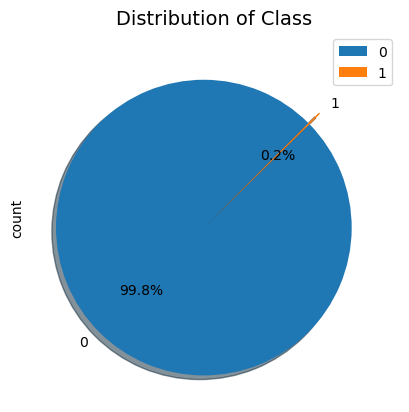

In [3]:
df['Class'].value_counts().plot.pie(explode=[0.1,0],autopct='%3.1f%%'
                                     ,shadow=True, legend= True,startangle =45)
plt.title('Distribution of Class',size=14)
plt.show()

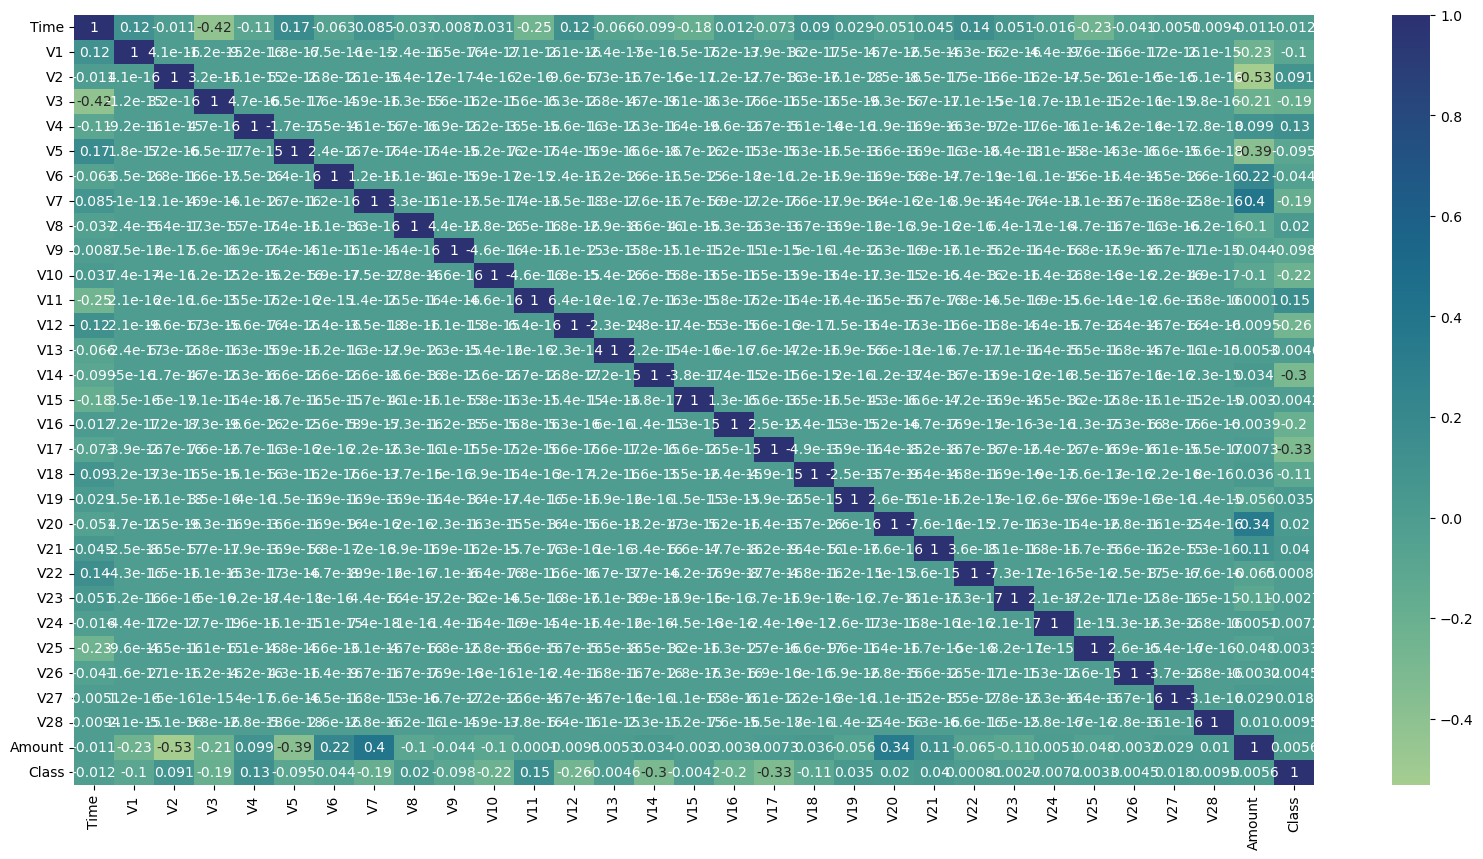

In [4]:
paper = plt.figure(figsize=[20,10])
sns.heatmap(df.corr(),cmap='crest',annot=True)
plt.show()

<Axes: >

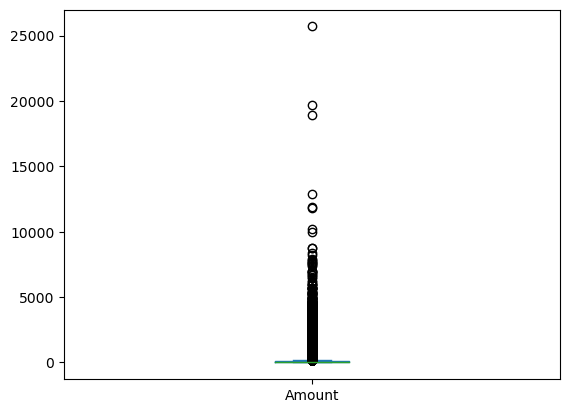

In [5]:
df['Amount'].plot.box()

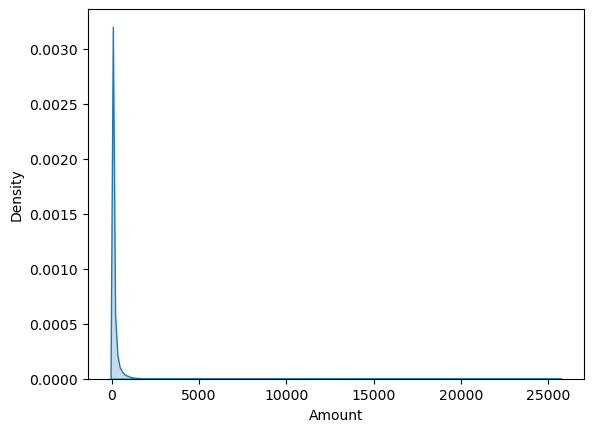

In [6]:
sns.kdeplot(data=df['Amount'], shade=True)
plt.show()

We have 0.17% fraud cases in the dataset which are anomalies.

Only `Time` and `Amount` have not been transformed with PCA. Time contains the seconds elapsed between each transaction and the first transaction in the dataset. Lets transofrm this feature into hours to get a better understanding.

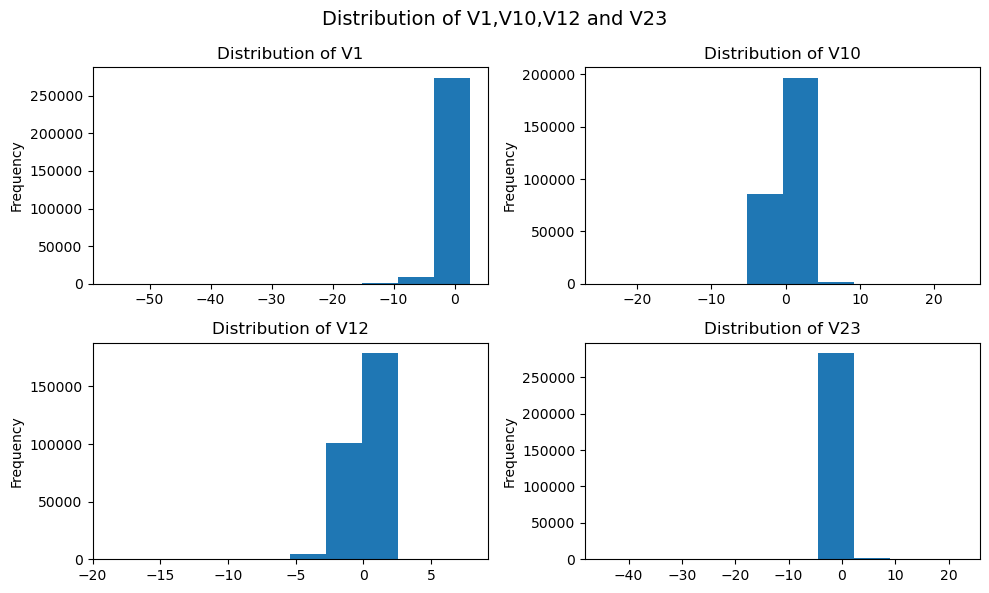

In [7]:
# Lets plot a histogram
paper, axes = plt.subplots(2, 2, figsize=(10, 6))
df['V1'].plot(kind='hist', ax=axes[0,0], title='Distribution of V1')
df['V10'].plot(kind='hist', ax=axes[0,1], title='Distribution of V10')
df['V12'].plot(kind='hist', ax=axes[1,0], title='Distribution of V12')
df['V23'].plot(kind='hist', ax=axes[1,1], title='Distribution of V23')
plt.suptitle('Distribution of V1,V10,V12 and V23',size=14)
plt.tight_layout()
plt.show()

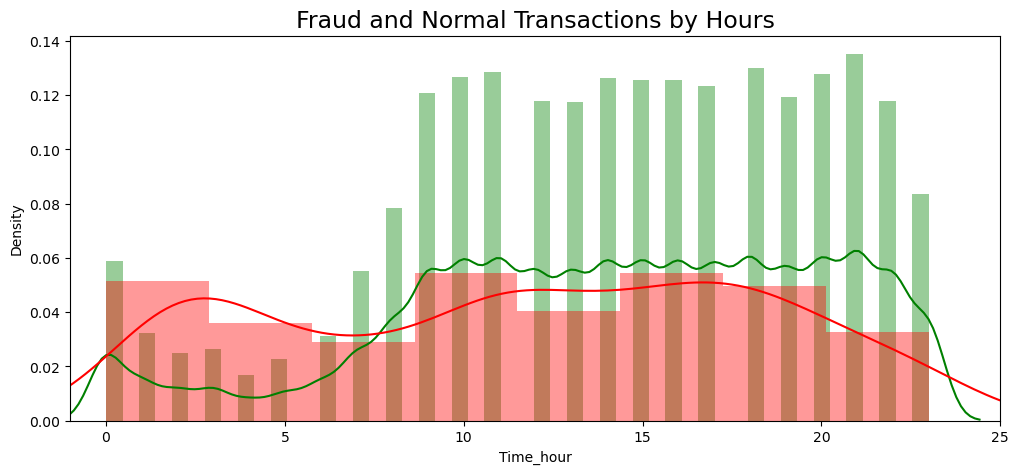

In [8]:
timedelta = pd.to_timedelta(df['Time'], unit='s')
df['Time_hour'] = (timedelta.dt.components.hours).astype(int)

plt.figure(figsize=(12,5))
sns.distplot(df[df['Class'] == 0]["Time_hour"], color='g')
sns.distplot(df[df['Class'] == 1]["Time_hour"], color='r')
plt.title('Fraud and Normal Transactions by Hours', fontsize=17)
plt.xlim([-1,25])
plt.show()

Seems like hour of day have some impact on number or fraud cases. Lets move to transform the remaining features.

### Feature Transformation

Lets transform the remaining features using PCA.

In [9]:
cols= df[['Time', 'Amount']]

pca = PCA()
pca.fit(cols)
X_PCA = pca.transform(cols)

df['V29']=X_PCA[:,0]
df['V30']=X_PCA[:,1]


df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'Time_hour', 'V29', 'V30'],
      dtype='object')

Now lets have a view at distribution of features

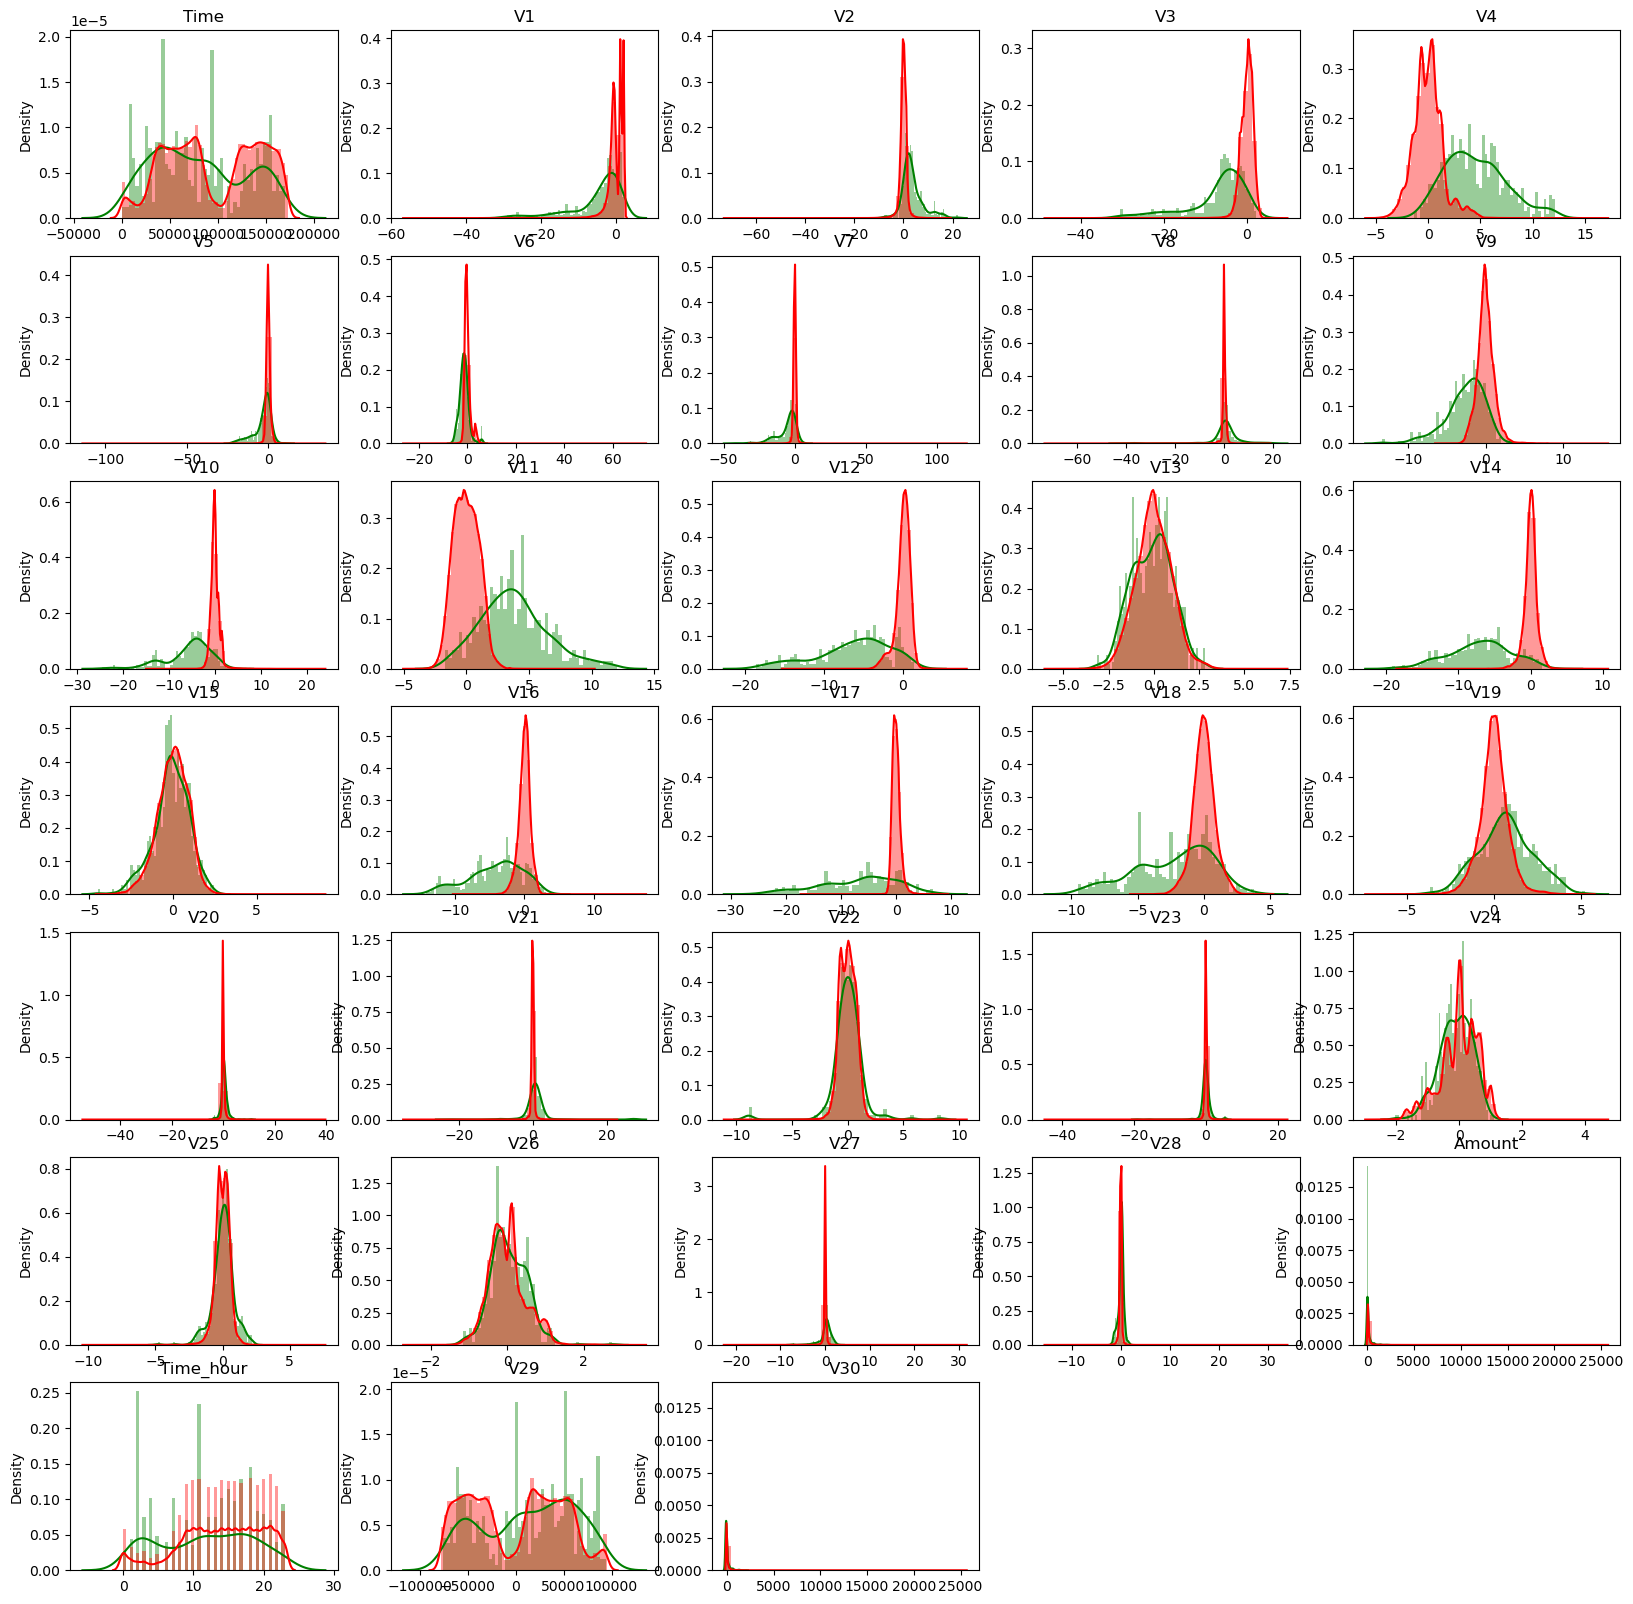

In [10]:
columns = df.drop('Class', axis=1).columns
grid = gridspec.GridSpec(7, 5)

plt.figure(figsize=(20,10*2))

for n, col in enumerate(df[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(df[df.Class==1][col], bins = 50, color='g')
    sns.distplot(df[df.Class==0][col], bins = 50, color='r') 
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
    
plt.show()

## Feature Selection using Statistical  Method


In [11]:
df.groupby('Class').corr()

Time        V1        V2        V3        V4        V5  \
Class                                                                         
0     Time       1.000000  0.116489 -0.008408 -0.441001 -0.104329  0.172963   
      V1         0.116489  1.000000  0.022537 -0.047511  0.020927 -0.031465   
      V2        -0.008408  0.022537  1.000000  0.037855 -0.018318  0.023772   
      V3        -0.441001 -0.047511  0.037855  1.000000  0.039621 -0.048840   
      V4        -0.104329  0.020927 -0.018318  0.039621  1.000000  0.020792   
...                   ...       ...       ...       ...       ...       ...   
1     V28        0.039952  0.284370 -0.056688  0.247184 -0.232332  0.251549   
      Amount     0.048732  0.048216 -0.272762  0.089994 -0.133795 -0.052031   
      Time_hour  0.452598  0.315348 -0.394479  0.410824 -0.422757  0.346935   
      V29       -1.000000 -0.263358  0.255465 -0.209597  0.196576 -0.320502   
      V30        0.059100  0.050927 -0.275265  0.092122 -0.135763 -0.048670   

                       V6        V7        V8        V9  ...       V23  \
Class                                                    ...             
0     Time      -0.064131  0.084172 -0.035954 -0.010577  ...  0.051167   
      V1        -0.006405 -0.053563  0.004444 -0.018962  ...  0.000720   
      V2         0.004879  0.042034 -0.000308  0.016215  ... -0.002049   
      V3        -0.013294 -0.084853  0.012717 -0.033957  ...  0.000592   
      V4         0.007452  0.041284 -0.004830  0.019998  ... -0.000146   
...                   ...       ...       ...       ...  ...       ...   
1     V28       -0.000370  0.245928 -0.020636  0.275593  ...  0.075497   
      Amount     0.228130  0.201334  0.036081  0.132235  ... -0.166725   
      Time_hour  0.191503  0.375894 -0.077716  0.247386  ...  0.021786   
      V29       -0.143117 -0.231853  0.183096 -0.152750  ... -0.062406   
      V30        0.229490  0.203631  0.034157  0.133749  ... -0.165983   

                      V24       V25       V26       V27       V28    Amount  \
Class                                                                         
0     Time      -0.016259 -0.233290 -0.041353 -0.003859 -0.009442 -0.010634   
      V1         0.000269  0.001181 -0.000334 -0.003843 -0.001883 -0.231250   
      V2         0.000359 -0.001272 -0.000171  0.002333 -0.000455 -0.536546   
      V3        -0.000909  0.001990  0.000621 -0.002033 -0.001536 -0.219130   
      V4         0.001056  0.000022 -0.001424 -0.001003  0.000076  0.099802   
...                   ...       ...       ...       ...       ...       ...   
1     V28       -0.053794  0.215974  0.031997  0.279621  1.000000 -0.118918   
      Amount     0.083108 -0.128156 -0.077508  0.095961 -0.118918  1.000000   
      Time_hour -0.105725  0.103794  0.046730  0.155541  0.122635  0.063654   
      V29        0.025825  0.167605  0.042885  0.186088 -0.039952 -0.048732   
      V30        0.082793 -0.129827 -0.077910  0.093972 -0.118436  0.999946   

                 Time_hour       V29       V30  
Class                                           
0     Time        0.415389 -1.000000 -0.000037  
      V1         -0.009254 -0.116489 -0.230029  
      V2          0.011512  0.008408 -0.536665  
      V3         -0.029842  0.441001 -0.223816  
      V4         -0.031526  0.104329  0.098702  
...                    ...       ...       ...  
1     V28         0.122635 -0.039952 -0.118436  
      Amount      0.063654 -0.048732  0.999946  
      Time_hour   1.000000 -0.452598  0.068323  
      V29        -0.452598  1.000000 -0.059100  
      V30         0.068323 -0.059100  1.000000  

[66 rows x 33 columns]

In [12]:
mean = df.groupby('Class').mean()

In [13]:
mean_df = mean.to_csv('C:\\Users\\AMJAD\\AD\\Paper 2 - Anomaly Detection In Multivariate Time Series Data Using Deep Ensemble Models\\Datasets\\mean.csv')


In [14]:
mean.loc['Diff'] = mean.iloc[0]  - mean.iloc[1] 

In [15]:
mean

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Time_hour,V29,V30
Class,,,,,,,,,,,,,,,,,,,,,
0,94838.202258,0.008258,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467,...,0.000070,0.000182,-0.000072,-0.000089,-0.000295,-0.000131,88.291022,14.050623,-24.342686,-0.057238
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,11.646341,14067.054533,33.076582
Diff,14091.395347,4.780206,-3.630049,7.045452,-4.549889,3.156678,1.400155,5.578368,-0.571623,2.585589,...,0.040378,0.105312,-0.041521,-0.051738,-0.170870,-0.075798,-33.920299,2.404282,-14091.397219,-33.133820


In [16]:
# importing statistics module
import math
from statistics import variance
variance=df.groupby('Class').var()

In [17]:
variance

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Time_hour,V29,V30
Class,,,,,,,,,,,,,,,,,,,,,
0,2.254732e+09,3.724182,2.676974,2.129933,1.958134,1.841318,1.768669,1.389598,1.348579,1.186731,...,0.386313,0.366965,0.271101,0.232556,0.159877,0.108616,62552.557157,34.029469,2.254732e+09,62545.483812
1,2.288222e+09,46.018406,18.414532,50.565429,8.255955,28.863413,3.452623,51.937575,46.210501,6.254479,...,2.495270,0.265819,0.635535,0.222481,1.895484,0.299528,65886.310491,44.400129,2.288222e+09,65960.229921


In [18]:
variance_df =variance.to_csv('C:\\Users\\AMJAD\\AD\\Paper 2 - Anomaly Detection In Multivariate Time Series Data Using Deep Ensemble Models\\Datasets\\variance.csv')


In [19]:
variance.loc['Diff']= variance.iloc[0] + variance.iloc[1]

In [20]:
variance.loc['Diff1']=variance.iloc[2] / 28
#variance.loc['Diff1']=variance.iloc[3] / 10

In [21]:
variance.loc['Diff2']=np.sqrt(variance.iloc[3])
#variance.loc['Diff2']=np.sqrt(variance.iloc[4])

In [22]:
variance

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Time_hour,V29,V30
Class,,,,,,,,,,,,,,,,,,,,,
0,2.254732e+09,3.724182,2.676974,2.129933,1.958134,1.841318,1.768669,1.389598,1.348579,1.186731,...,0.386313,0.366965,0.271101,0.232556,0.159877,0.108616,62552.557157,34.029469,2.254732e+09,62545.483812
1,2.288222e+09,46.018406,18.414532,50.565429,8.255955,28.863413,3.452623,51.937575,46.210501,6.254479,...,2.495270,0.265819,0.635535,0.222481,1.895484,0.299528,65886.310491,44.400129,2.288222e+09,65960.229921
Diff,4.542954e+09,49.742588,21.091505,52.695362,10.214088,30.704730,5.221292,53.327173,47.559080,7.441210,...,2.881583,0.632784,0.906636,0.455037,2.055361,0.408144,128438.867649,78.429598,4.542954e+09,128505.713733
Diff1,1.622484e+08,1.776521,0.753268,1.881977,0.364789,1.096598,0.186475,1.904542,1.698539,0.265757,...,0.102914,0.022599,0.032380,0.016251,0.073406,0.014577,4587.102416,2.801057,1.622484e+08,4589.489776
Diff2,1.273767e+04,1.332862,0.867910,1.371852,0.603978,1.047186,0.431827,1.380051,1.303280,0.515517,...,0.320802,0.150331,0.179944,0.127481,0.270935,0.120734,67.728151,1.673636,1.273767e+04,67.745773


In [23]:
metric=mean.iloc[2]/variance.iloc[4]
#metric=mean.iloc[3]/variance.iloc[5]

In [24]:
abs(metric)

Time         1.106277
V1           3.586423
V2           4.182517
V3           5.135724
V4           7.533209
V5           3.014440
V6           3.242398
V7           4.042145
V8           0.438604
V9           5.015530
V10          6.009320
V11          7.042485
V12          6.985609
V13          0.389831
V14          8.452688
V15          0.353686
V16          5.546740
V17          5.039849
V18          3.949967
V19          2.072689
V20          1.272481
V21          0.961211
V22          0.044845
V23          0.125865
V24          0.700535
V25          0.230742
V26          0.405846
V27          0.630668
V28          0.627814
Amount       0.500830
Time_hour    1.436562
V29          1.106277
V30          0.489091
dtype: float64

In [25]:
abs(metric).sort_values( ascending=False)

V14          8.452688
V4           7.533209
V11          7.042485
V12          6.985609
V10          6.009320
V16          5.546740
V3           5.135724
V17          5.039849
V9           5.015530
V2           4.182517
V7           4.042145
V18          3.949967
V1           3.586423
V6           3.242398
V5           3.014440
V19          2.072689
Time_hour    1.436562
V20          1.272481
V29          1.106277
Time         1.106277
V21          0.961211
V24          0.700535
V27          0.630668
V28          0.627814
Amount       0.500830
V30          0.489091
V8           0.438604
V26          0.405846
V13          0.389831
V15          0.353686
V25          0.230742
V23          0.125865
V22          0.044845
dtype: float64

In [26]:
def smtest(feature):
    
    mean = df.groupby('Class').mean()
    mean.loc['Diff'] = mean.iloc[0]  - mean.iloc[1] 
    # importing statistics module
    import math
    from statistics import variance
    variance=df.groupby('Class').var()
    variance.loc['Diff']= variance.iloc[0] + variance.iloc[1]
    variance.loc['Diff1']=variance.iloc[2] / 28
    variance.loc['Diff2']=np.sqrt(variance.iloc[3])
    metric=mean.iloc[2]/variance.iloc[4]
    abs(metric)
    fMetrix=abs(metric).sort_values( ascending=False)
    
    return fMetrix

In [27]:

df.drop(['V21','V24','V27','V28','Amount','V30','V8','V26','V13','V15','V25','V23','V22',], axis=1, inplace=True)


In [28]:

X = df.drop("Class", axis=1)
y = df["Class"]
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [29]:


# Split the resampled data into train and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [30]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [31]:
# Reshape the data for CNN input
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)



In [32]:
# Reshape the data for LSTM input
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [33]:
# Define and train the 1D CNN model
cnn_model = keras.Sequential()
cnn_model.add(layers.Conv1D(32, kernel_size=5, activation="relu", input_shape=(X_train_cnn.shape[1], 1)))
cnn_model.add(layers.MaxPooling1D(pool_size=2))
cnn_model.add(layers.Conv1D(64, kernel_size=5, activation="relu"))
cnn_model.add(layers.MaxPooling1D(pool_size=2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation="relu"))
cnn_model.add(layers.Dense(1, activation="sigmoid"))
cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
cnn_model.summary()

cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=64, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 32)            192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 8, 32)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 64)             10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8

In [34]:
# Define and train the LSTM model
lstm_model = keras.Sequential()
lstm_model.add(layers.LSTM(50, activation="relu", input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(layers.Dense(1, activation="sigmoid"))
lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
lstm_model.summary()

lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=64, validation_split=0.2)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2493/2493 [==============================] - 54s 20ms/step - loss: 0.0273 - accuracy: 0.9986 - val_loss: 0.0046 - val_accuracy: 0.9990
Epoch 2/10
2493/2493 [==============================] - 51s 20ms/step - loss: 0.0046 - accuracy: 0.9992 - val_loss: 0.0037 - val_accuracy: 0.9994
Epoch 3/10
2493/2493 [==============================] - 52s 21ms/step - loss: 0.0042 - accuracy: 0.9993 - val_loss: 0.0036 - val_accuracy: 0.9992
Epoch 4/

In [35]:
# Function to optimize the threshold
def find_best_threshold(y_true, y_pred):
    thresholds = np.arange(0, 1, 0.01)
    best_f1 = 0
    best_threshold = 0

    for threshold in thresholds:
        y_pred_binary = (y_pred > threshold).astype(int)
        f1 = f1_score(y_true, y_pred_binary)
        
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold

In [36]:

# Predictions from individual models
y_pred_cnn = cnn_model.predict(X_test_cnn)
y_pred_lstm = lstm_model.predict(X_test_lstm)


2671/2671 [==============================] - 17s 6ms/step


In [37]:
# Find the best threshold for the models
best_threshold_cnn = find_best_threshold(y_test, y_pred_cnn)
best_threshold_lstm = find_best_threshold(y_test, y_pred_lstm)


In [38]:
# Apply the best threshold to classify fraud and non-fraud for individual models
y_pred_cnn_binary = (y_pred_cnn > best_threshold_cnn).astype(int)
y_pred_lstm_binary = (y_pred_lstm > best_threshold_lstm).astype(int)


In [39]:
# Calculate performance metrics for the CNN
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn_binary)
accuracy_cnn = accuracy_score(y_test, y_pred_cnn_binary)
precision_cnn = precision_score(y_test, y_pred_cnn_binary)
recall_cnn = recall_score(y_test, y_pred_cnn_binary)
f1_cnn = f1_score(y_test, y_pred_cnn_binary)
roc_auc_cnn = roc_auc_score(y_test, y_pred_cnn_binary)
precision_cnn, recall_cnn, _ = precision_recall_curve(y_test, y_pred_cnn_binary)
pr_auc_cnn = auc(recall_cnn, precision_cnn)
mcc_cnn = matthews_corrcoef(y_test, y_pred_cnn_binary)
r2 = r2_score(y_test, y_pred_cnn_binary)

In [40]:
# Print the CNN model evaluation metrics
print("Performance Metrics for the CNN Model:")
print("Confusion Matrix CNN:\n", conf_matrix_cnn)
print("Accuracy:", accuracy_cnn)
print("Precision:", precision_cnn)
print("Recall:", recall_cnn)
print("F1 Score:", f1_cnn)
print("ROC AUC:", roc_auc_cnn)
print("PR AUC:", pr_auc_cnn)
print("MCC:", mcc_cnn)
print("R-squared (R2) Score:", r2)
print("Anomaly Detection Rate:", np.sum(y_pred_cnn_binary) / len(y_pred_cnn_binary))
print("False Positive Rate:", recall_cnn[1])
classification = classification_report(y_test, y_pred_cnn_binary)
print("Classification Report:")
print(classification)

Performance Metrics for the CNN Model:
Confusion Matrix Ensemble:
 [[85281    26]
 [   19   117]]
Accuracy: 0.9994733330992591
Precision: [0.0015917  0.81818182 1.        ]
Recall: [1.         0.86029412 0.        ]
F1 Score: 0.8387096774193549
ROC AUC: 0.9299946680466881
PR AUC: 0.8393491531490395
MCC: 0.8387109643937851
R-squared (R2) Score: 0.6685901405236039
Anomaly Detection Rate: 0.0016736303734653513
False Positive Rate: 0.8602941176470589
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.82      0.86      0.84       136

    accuracy                           1.00     85443
   macro avg       0.91      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [41]:

# Display and plot individual model results
print("Individual Models:")
print("CNN Model Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_cnn_binary))
print("Precision:", precision_score(y_test, y_pred_cnn_binary))
print("Recall:", recall_score(y_test, y_pred_cnn_binary))
print("F1-Score:", f1_score(y_test, y_pred_cnn_binary))
print("MSE:", mean_squared_error(y_test, y_pred_cnn_binary))
print("ROC:", roc_auc_score(y_test, y_pred_cnn_binary))
print("R2 Score:", r2_score(y_test, y_pred_cnn_binary))
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn_binary)
print("Confusion Matrix:")
print(conf_matrix_cnn)
classification = classification_report(y_test, y_pred_cnn_binary)
print("Classification Report:")
print(classification)

Individual Models:
CNN Model Results:
Accuracy: 0.9994733330992591
Precision: 0.8181818181818182
Recall: 0.8602941176470589
F1-Score: 0.8387096774193549
MSE: 0.0005266669007408447
ROC: 0.9299946680466881
R2 Score: 0.6685901405236039
Confusion Matrix:
[[85281    26]
 [   19   117]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.82      0.86      0.84       136

    accuracy                           1.00     85443
   macro avg       0.91      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443



In [42]:
# Calculate performance metrics for the CNN
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm_binary)
accuracy_lstm = accuracy_score(y_test, y_pred_lstm_binary)
precision_lstm = precision_score(y_test, y_pred_lstm_binary)
recall_lstm = recall_score(y_test, y_pred_lstm_binary)
f1_lstm = f1_score(y_test, y_pred_lstm_binary)
roc_auc_lstm = roc_auc_score(y_test, y_pred_lstm_binary)
precision_lstm, recall_lstm, _ = precision_recall_curve(y_test, y_pred_lstm_binary)
pr_auc_lstm = auc(recall_lstm, precision_lstm)
mcc_lstm = matthews_corrcoef(y_test, y_pred_lstm_binary)
r2 = r2_score(y_test, y_pred_lstm_binary)

In [43]:
# Print the LSTM model evaluation metrics
print("Performance Metrics for the LSTM Model:")
print("Confusion Matrix Ensemble:\n", conf_matrix_lstm)
print("Accuracy:", accuracy_lstm)
print("Precision:", precision_lstm)
print("Recall:", recall_lstm)
print("F1 Score:", f1_lstm)
print("ROC AUC:", roc_auc_lstm)
print("PR AUC:", pr_auc_lstm)
print("MCC:", mcc_lstm)
print("R-squared (R2) Score:", r2)
print("Anomaly Detection Rate:", np.sum(y_pred_lstm_binary) / len(y_pred_lstm_binary))
print("False Positive Rate:", recall_lstm[1])
classification = classification_report(y_test, y_pred_lstm_binary)
print("Classification Report:")
print(classification)

Performance Metrics for the LSTM Model:
Confusion Matrix Ensemble:
 [[85276    31]
 [   20   116]]
Accuracy: 0.999403110845827
Precision: [0.0015917  0.78911565 1.        ]
Recall: [1.         0.85294118 0.        ]
F1 Score: 0.8197879858657242
ROC AUC: 0.9262888915398295
PR AUC: 0.8211454484535994
MCC: 0.8201113082392214
R-squared (R2) Score: 0.6244021592600844
Anomaly Detection Rate: 0.0017204452090867595
False Positive Rate: 0.8529411764705882
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.79      0.85      0.82       136

    accuracy                           1.00     85443
   macro avg       0.89      0.93      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [44]:
print("LSTM Model Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_lstm_binary))
print("Precision:", precision_score(y_test, y_pred_lstm_binary))
print("Recall:", recall_score(y_test, y_pred_lstm_binary))
print("F1-Score:", f1_score(y_test, y_pred_lstm_binary))
#print("MSE:", mean_squared_error(y_test, y_pred_lstm_binary))
print("ROC:", roc_auc_score(y_test, y_pred_lstm_binary))
print("R2 Score:", r2_score(y_test, y_pred_lstm_binary))
conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm_binary)
print("Confusion Matrix:")
print(conf_matrix_lstm)
classification = classification_report(y_test, y_pred_lstm_binary)
print("Classification Report:")
print(classification)

LSTM Model Results:
Accuracy: 0.999403110845827
Precision: 0.7891156462585034
Recall: 0.8529411764705882
F1-Score: 0.8197879858657242
MSE: 0.0005968891541729574
ROC: 0.9262888915398295
R2 Score: 0.6244021592600844
Confusion Matrix:
[[85276    31]
 [   20   116]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.79      0.85      0.82       136

    accuracy                           1.00     85443
   macro avg       0.89      0.93      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [45]:
# Apply the best threshold to classify fraud and non-fraud for the ensemble model
y_pred_ensemble = (0.5 * (y_pred_cnn + y_pred_lstm) > 0.5).astype(int)

# Calculate performance metrics for the Ensemble
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
precision_ensemble = precision_score(y_test, y_pred_ensemble)
recall_ensemble = recall_score(y_test, y_pred_ensemble)
f1_ensemble = f1_score(y_test, y_pred_ensemble)
roc_auc_ensemble = roc_auc_score(y_test, y_pred_ensemble)
precision_ensemble, recall_ensemble, _ = precision_recall_curve(y_test, y_pred_ensemble)
pr_auc_ensemble = auc(recall_ensemble, precision_ensemble)
mcc_ensemble = matthews_corrcoef(y_test, y_pred_ensemble)
r2 = r2_score(y_test, y_pred_ensemble)

In [46]:
# Print the ensemble model evaluation metrics
print("Performance Metrics for the CNN LSTM Ensemble Model:")
print("Confusion Matrix Ensemble:\n", conf_matrix_ensemble)
print("Accuracy:", accuracy_ensemble)
print("Precision:", precision_ensemble)
print("Recall:", recall_ensemble)
print("F1 Score:", f1_ensemble)
print("ROC AUC:", roc_auc_ensemble)
print("PR AUC:", pr_auc_ensemble)
print("MCC:", mcc_ensemble)
print("R-squared (R2) Score:", r2)
print("Anomaly Detection Rate:", np.sum(y_pred_ensemble) / len(y_pred_ensemble))
print("False Positive Rate:", recall_ensemble[1])
classification = classification_report(y_test, y_pred_ensemble)
print("Classification Report:")
print(classification)

Performance Metrics for the CNN Model:
Confusion Matrix Ensemble:
 [[85280    27]
 [   24   112]]
Accuracy: 0.999403110845827
Precision: [0.0015917 0.8057554 1.       ]
Recall: [1.         0.82352941 0.        ]
F1 Score: 0.8145454545454545
ROC AUC: 0.911606453921787
PR AUC: 0.8147828482309437
MCC: 0.8142951762386657
R-squared (R2) Score: 0.6244021592600844
Anomaly Detection Rate: 0.0016268155378439428
False Positive Rate: 0.8235294117647058
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.81      0.82      0.81       136

    accuracy                           1.00     85443
   macro avg       0.90      0.91      0.91     85443
weighted avg       1.00      1.00      1.00     85443



In [47]:

# Apply the best threshold to classify fraud and non-fraud for the ensemble model
y_pred_ensemble = (0.5 * (y_pred_cnn + y_pred_lstm) > 0.5).astype(int)

# Display and plot ensemble model results
print("Ensemble Model Results with Optimized Threshold:")
print("Accuracy:", accuracy_score(y_test, y_pred_ensemble))
print("Precision:", precision_score(y_test, y_pred_ensemble))
print("Recall:", recall_score(y_test, y_pred_ensemble))
print("F1-Score:", f1_score(y_test, y_pred_ensemble))
print("MSE:", mean_squared_error(y_test, y_pred_ensemble))
print("ROC:", roc_auc_score(y_test, y_pred_ensemble))
print("R2 Score:", r2_score(y_test, y_pred_ensemble))

conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)
print("Confusion Matrix:")
print(conf_matrix_ensemble)
classification = classification_report(y_test, y_pred_ensemble)
print("Classification Report:")
print(classification)

Ensemble Model Results with Optimized Threshold:
Accuracy: 0.999403110845827
Precision: 0.8057553956834532
Recall: 0.8235294117647058
F1-Score: 0.8145454545454545
MSE: 0.0005968891541729574
ROC: 0.911606453921787
R2 Score: 0.6244021592600844
Confusion Matrix:
[[85280    27]
 [   24   112]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.81      0.82      0.81       136

    accuracy                           1.00     85443
   macro avg       0.90      0.91      0.91     85443
weighted avg       1.00      1.00      1.00     85443



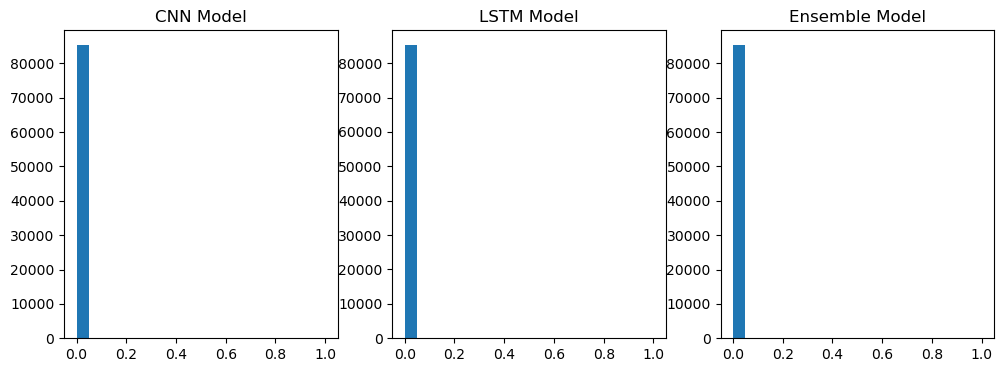

In [48]:
# Plot the results
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title("CNN Model")
plt.hist(y_pred_cnn_binary, bins=20)
plt.subplot(132)
plt.title("LSTM Model")
plt.hist(y_pred_lstm_binary, bins=20)
plt.subplot(133)
plt.title("Ensemble Model")
plt.hist(y_pred_ensemble, bins=20)
plt.show()


In [49]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Function to plot ROC curve
def plot_roc(y_true, y_pred, label):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')


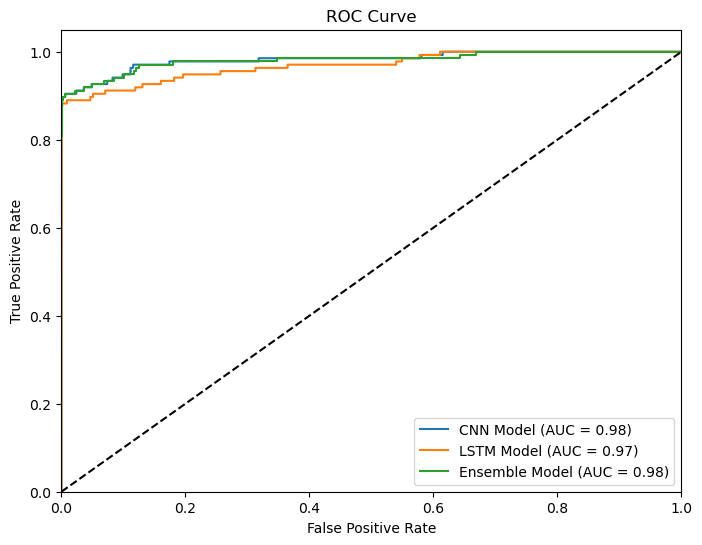

In [50]:

# Plot ROC curves for individual models and ensemble
plt.figure(figsize=(8, 6))

# CNN Model
plot_roc(y_test, y_pred_cnn, 'CNN Model')

# LSTM Model
plot_roc(y_test, y_pred_lstm, 'LSTM Model')

# Ensemble Model
plot_roc(y_test, 0.5 * (y_pred_cnn + y_pred_lstm), 'Ensemble Model')

plt.plot([0, 1], [0, 1], 'k--')  # Random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()
